In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs6353/assignments/assignment1/'
FOLDERNAME = 'assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs6353/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignment1/cs6353/datasets
--2023-09-24 05:29:12--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  44.3MB/s    in 4.1s    

2023-09-24 05:29:16 (39.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs6353/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs6353/classifiers/softmax.py**.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs6353/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs6353.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.357637
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Currently we are not learning anything and since we are calculating the loss based on random weights at the start each class has equal probability of being chosen.
We have ten classes so for each class the probabilty of being picked = 1/10 hence we expect our ansswer to log(0.1)


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs6353.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.154714 analytic: 2.154714, relative error: 4.163127e-08
numerical: 0.776357 analytic: 0.776357, relative error: 4.084981e-08
numerical: 1.466598 analytic: 1.466598, relative error: 1.380857e-08
numerical: -0.895444 analytic: -0.895444, relative error: 5.145363e-08
numerical: 2.644578 analytic: 2.644578, relative error: 2.623047e-08
numerical: 3.838398 analytic: 3.838398, relative error: 2.017235e-08
numerical: 3.016777 analytic: 3.016777, relative error: 2.134895e-08
numerical: 1.952853 analytic: 1.952853, relative error: 5.358747e-08
numerical: 1.613410 analytic: 1.613409, relative error: 5.204615e-08
numerical: -1.111051 analytic: -1.111051, relative error: 5.426977e-08
numerical: -4.647362 analytic: -4.647362, relative error: 9.440310e-09
numerical: -0.929889 analytic: -0.929889, relative error: 1.956329e-08
numerical: 3.668141 analytic: 3.668141, relative error: 1.049680e-09
numerical: 0.092834 analytic: 0.092834, relative error: 4.700325e-08
numerical: 1.109949 analyt

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs6353.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.357637e+00 computed in 0.059253s
vectorized loss: 2.357637e+00 computed in 0.011650s
Loss difference: 0.000000
Gradient difference: 0.000000


In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs6353.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 3e-7, 4.5e-7, 1.5e-7]
regularization_strengths = [2.5e4, 3e4 , 1e4, 1.5e4 ,3.5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifier in best_softmax.                          #
################################################################################
# Your code
softmaxModel = Softmax()

for learning_rate in learning_rates:
    for regularization in regularization_strengths:
        loss = softmaxModel.train(X_train, y_train, learning_rate=learning_rate, reg=regularization, num_iters=2000)

        yTrain_pred = softmaxModel.predict(X_train)
        acc_train = np.mean(y_train == yTrain_pred)

        yVal_pred = softmaxModel.predict(X_val)
        acc_val = np.mean(y_val == yVal_pred)

        results[(learning_rate, regularization)] = (acc_train, acc_val)

        if acc_val > best_val:
            best_val = acc_val
            best_softmax = softmaxModel
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.358612 val accuracy: 0.369000
lr 1.000000e-07 reg 1.500000e+04 train accuracy: 0.343776 val accuracy: 0.356000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.328449 val accuracy: 0.347000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.322347 val accuracy: 0.330000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.323327 val accuracy: 0.332000
lr 1.500000e-07 reg 1.000000e+04 train accuracy: 0.356755 val accuracy: 0.376000
lr 1.500000e-07 reg 1.500000e+04 train accuracy: 0.345939 val accuracy: 0.352000
lr 1.500000e-07 reg 2.500000e+04 train accuracy: 0.336571 val accuracy: 0.351000
lr 1.500000e-07 reg 3.000000e+04 train accuracy: 0.322816 val accuracy: 0.335000
lr 1.500000e-07 reg 3.500000e+04 train accuracy: 0.321122 val accuracy: 0.331000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.352020 val accuracy: 0.359000
lr 3.000000e-07 reg 1.500000e+04 train accuracy: 0.347367 val accuracy: 0.367000
lr 3.000000e-07 reg 2.500000

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.335000


**Inline Question** - *True or False*

It's possible to add a new data point to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*: the statement is True

*Your explanation*: For the case of SVM if the new data point generates a score which is less than the deta that of the correct class score then this new data point will not contribute to the loss.
On the other hand Softmax calculates the loss by considering the socre of every data point for its loss generation. As it calculates the probability of classes if a new class is added then it will definitely have an effect on the total loss.

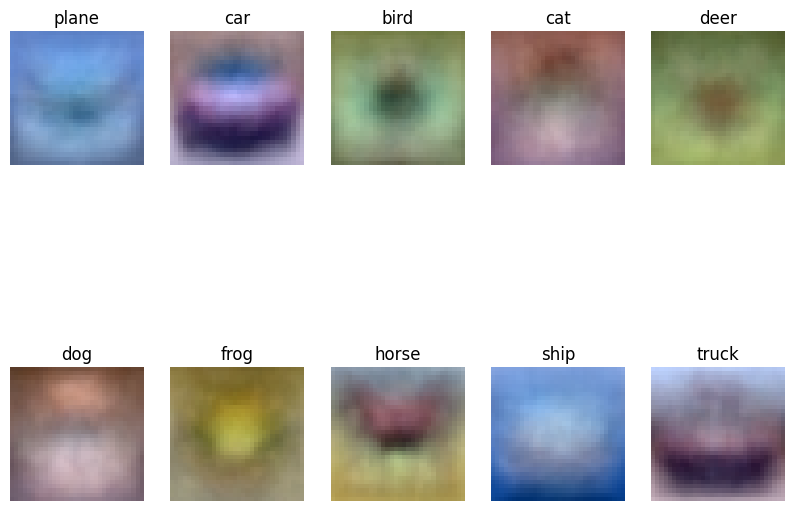

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [11]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/assignment1/softmax.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/assignment1/softmax.ipynb to html
[NbConvertApp] Writing 681344 bytes to /content/drive/MyDrive/assignment1/softmax.html
